EXPLORE KNEE DATA

>1500 knee images with:
- 1.5 and 3 Tesla
- raw dataset: includes coronal PD weighted images with and without fat supression


In [1]:
%matplotlib inline

import h5py
import numpy as np
import fastmri
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Knee'
train_path = Path(f"{download_path}/multicoil_train")
validation_path = Path(f"{download_path}/multicoil_val")
test_path = Path(f"{download_path}/multicoil_test")

In [7]:
train_list = list(test_path.glob('*.h5'))  # list of all files in the train folder
print(len(train_list))

file_name = train_list[0]
hf = h5py.File(file_name,'r')

118


In [8]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))


Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPD_FBK', 'num_low_frequency': 15, 'patient_id': '74a218268e94564bf6d1ab18026e9f7d1a916d9abb863a41980d880e39f42a25'}


Only keys are 'header' 'kspace' and 'reconstruction_rss' 
=> Meaning mathijs altered brain NYU data and added during Preprocessing!!: cs_data', 'grappa_data','sense_data'

In [5]:
print(hf.get('kspace'))             # (number of slices, number of coils, height, width)
print(hf.get('reconstruction_rss')) # (number of slices, height, width)
print(hf['ismrmrd_header'][()])    # xml file

<HDF5 dataset "kspace": shape (38, 15, 640, 368), type "<c8">
<HDF5 dataset "reconstruction_rss": shape (38, 320, 320), type "<f4">
b'<?xml version="1.0"?>\n<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xs="http://www.w3.org/2001/XMLSchema" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">\n\t<studyInformation>\n\t\t<studyTime>13:18:27</studyTime>\n\t</studyInformation>\n\t<measurementInformation>\n\t\t<measurementID>45167_41971728_41971737_283</measurementID>\n\t\t<patientPosition>FFS</patientPosition>\n\t\t<protocolName>COR</protocolName>\n\t\t<frameOfReferenceUID>1.3.12.2.1107.5.2.19.45167.1.20180201131325184.0.0.0</frameOfReferenceUID>\n\t</measurementInformation>\n\t<acquisitionSystemInformation>\n\t\t<systemVendor>SIEMENS</systemVendor>\n\t\t<systemModel>Skyra</systemModel>\n\t\t<systemFieldStrength_T>2.893620</systemFieldStrength_T>\n\t\t<relativeReceiverNoiseBandwidth>0.793000</relativeReceiverNoiseB

Analyze header:

In [6]:
import xmltodict

header = xmltodict.parse(hf['ismrmrd_header'][()])
print(list(header.keys()))



def extract_keys(data, parent_key=""):
    keys = []
    for key, value in data.items():
        full_key = f"{parent_key}.{key}" if parent_key else key
        keys.append(full_key)
        if isinstance(value, dict):  # If it's a nested dictionary, recurse
            keys.extend(extract_keys(value, full_key))
        elif isinstance(value, list):  # If it's a list, check the first item
            if value and isinstance(value[0], dict):
                keys.extend(extract_keys(value[0], full_key))
    return keys

# Example usage
keys = extract_keys(header)

# Print all unique keys
for key in sorted(keys):
    print(key)


['ismrmrdHeader']
ismrmrdHeader
ismrmrdHeader.@xmlns
ismrmrdHeader.@xmlns:xs
ismrmrdHeader.@xmlns:xsi
ismrmrdHeader.@xsi:schemaLocation
ismrmrdHeader.acquisitionSystemInformation
ismrmrdHeader.acquisitionSystemInformation.coilLabel
ismrmrdHeader.acquisitionSystemInformation.coilLabel.coilName
ismrmrdHeader.acquisitionSystemInformation.coilLabel.coilNumber
ismrmrdHeader.acquisitionSystemInformation.institutionName
ismrmrdHeader.acquisitionSystemInformation.receiverChannels
ismrmrdHeader.acquisitionSystemInformation.relativeReceiverNoiseBandwidth
ismrmrdHeader.acquisitionSystemInformation.systemFieldStrength_T
ismrmrdHeader.acquisitionSystemInformation.systemModel
ismrmrdHeader.acquisitionSystemInformation.systemVendor
ismrmrdHeader.encoding
ismrmrdHeader.encoding.encodedSpace
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm.x
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm.y
ismrmrdHeader.encoding.encodedSpace.fieldOfView_mm.z
ismr

In [7]:
reconSpace = header['ismrmrdHeader']['encoding']['reconSpace']
print(reconSpace)

encodedSpace = header['ismrmrdHeader']['encoding']['encodedSpace']
print(encodedSpace)

accelerationFactor = header['ismrmrdHeader']['encoding']['parallelImaging']['accelerationFactor']
print(accelerationFactor)   # R in PE direction and RO direction (is just 1)

sequenceParameters = header['ismrmrdHeader']['sequenceParameters']
print(sequenceParameters)   # TR, TE, TI, flip angle, etc.
                            # 

measurementInformation = header['ismrmrdHeader']['measurementInformation']
print(measurementInformation)   # Patient position, etc.

acquisitionSystemInformation = header['ismrmrdHeader']['acquisitionSystemInformation']
print(acquisitionSystemInformation)   # systemvendor, systemmodel, fieldstrength, etc.

systemFieldStrength_T = header['ismrmrdHeader']['acquisitionSystemInformation']['systemFieldStrength_T']
print("T=",systemFieldStrength_T)    # more or less 3T or 1.5T  (not exactly!)



OrderedDict([('matrixSize', OrderedDict([('x', '320'), ('y', '320'), ('z', '1')])), ('fieldOfView_mm', OrderedDict([('x', '140.000000'), ('y', '140.000000'), ('z', '3.000000')]))])
OrderedDict([('matrixSize', OrderedDict([('x', '640'), ('y', '368'), ('z', '1')])), ('fieldOfView_mm', OrderedDict([('x', '280.000000'), ('y', '161.419998'), ('z', '4.500000')]))])
OrderedDict([('kspace_encoding_step_1', '1'), ('kspace_encoding_step_2', '1')])
OrderedDict([('TR', '2870.000000'), ('TE', '33.000000'), ('TI', '100.000000'), ('flipAngle_deg', '140.000000'), ('sequence_type', 'TurboSpinEcho'), ('echo_spacing', '10.960000')])
OrderedDict([('measurementID', '45167_41971728_41971737_283'), ('patientPosition', 'FFS'), ('protocolName', 'COR'), ('frameOfReferenceUID', '1.3.12.2.1107.5.2.19.45167.1.20180201131325184.0.0.0')])
OrderedDict([('systemVendor', 'SIEMENS'), ('systemModel', 'Skyra'), ('systemFieldStrength_T', '2.893620'), ('relativeReceiverNoiseBandwidth', '0.793000'), ('receiverChannels', '15'

reconSpace and encodedSpace contain: 'matrixSize'  and 'fieldOfView_mm' ['x', 'y', 'z']
- reconSpace = final reconstructed image: matrixSize        =  width x height of 'reconstruction_rss'
- encodedSpace = raw k-space data acquisition: matrixSize   =  width x height of 'kspace'

NOT mentioned if fat supression or not!

voxel size can be calculated:


In [8]:
# Extract voxel size:  voxel size = FOV in mm / matrix size (#voxels)
pixelSizeX = float(reconSpace['fieldOfView_mm']['x'])/float(reconSpace['matrixSize']['x'])
pixelSizeY = float(reconSpace['fieldOfView_mm']['y'])/float(reconSpace['matrixSize']['y'])
pixelSizeZ = float(reconSpace['fieldOfView_mm']['z'])/float(reconSpace['matrixSize']['z'])
print(pixelSizeX, pixelSizeY, pixelSizeZ)

# based on Reconsspace and not encodeSpace, since reconsspace represents output image
# Can also simply be calculated from the rss reconstruction and kspace!!


0.4375 0.4375 3.0


VISUALIZE K_SPACE AND RECONSTRUCTION: of the raw data (fully sampled)

In [9]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.shape) # 38 slices, 15 coils, 640x368

(38, 15, 640, 368)


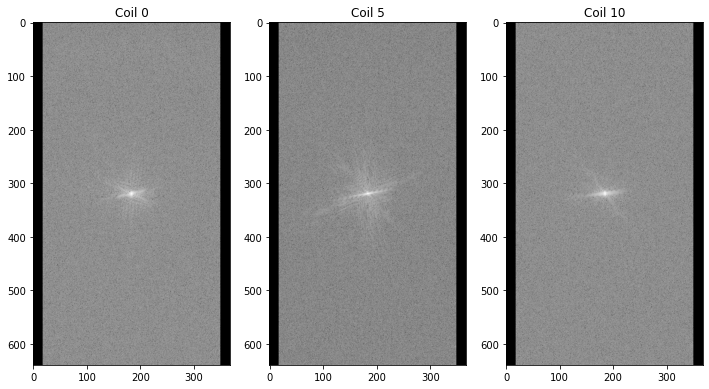

In [11]:
slice_kspace = volume_kspace[20]  

def show_coils(data, coil_nums, cmap=None):
    fig = plt.figure(figsize=(12,8))
    for i, num in enumerate(coil_nums):
        plt.subplot(1, len(coil_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.title(f"Coil {num}")

show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')  # This shows coils 0, 5 and 10
# Note: np.abs() on complex data is the same as calculating the magnitude. 1e-9 is added to avoid log(0).

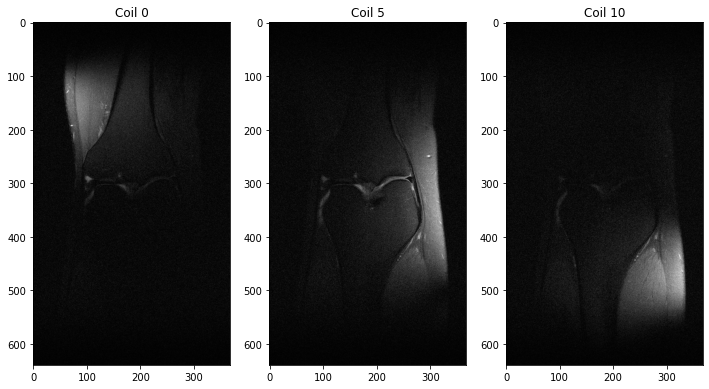

In [12]:
# reconstruction:
import fastmri
from fastmri.data import transforms as T

slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

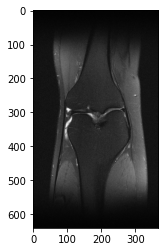

In [13]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

KSPACE AND RECONSTRUCTION OF UNDERSAMPLED DATA: (=input of our hybrid models)

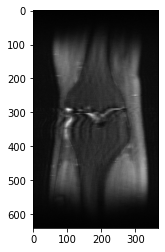

In [14]:
from fastmri.data.subsample import RandomMaskFunc
center_fractions = [0.08]
accelerations = [4]
mask_func = RandomMaskFunc(center_fractions, accelerations)  # Create the mask function object
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space


sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

VS RECONSTRUCTION OF CLASSICAL MODEL / HYBRID MODEL: